# А/В-тест для увеличения выручки магазина

У крупного интернет-магазина есть ряд гипотез для увеличения выручки, а также данные по А/В-тесту.

Цель: проаназировать данные А/В-теста, принять решение о его завершении/продолжении, подвести итоги.

Имеющиеся данные: 9 гипотез по улучшению выручки (/datasets/hypothesis.csv), результаты А/В-теста (/datasets/orders.csv и /datasets/visitors.csv).

План работ:
1. Ознакомление с данными и их подготовка.
2. Приоритизация гипотез.
3. Анализ А/В-теста.
4. Рекомендации для отдела маркетинга.

## Ознакомление и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
orders.duplicated().sum()

0

In [11]:
visitors.duplicated().sum()

0

In [12]:
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [13]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

В данных не обнаружены дубликаты и пропуски. Столбцы с датами приведены к формату datetime. Дополнительная доработка данных не требуется.

## Приоритизация гипотез

In [14]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values('ICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000


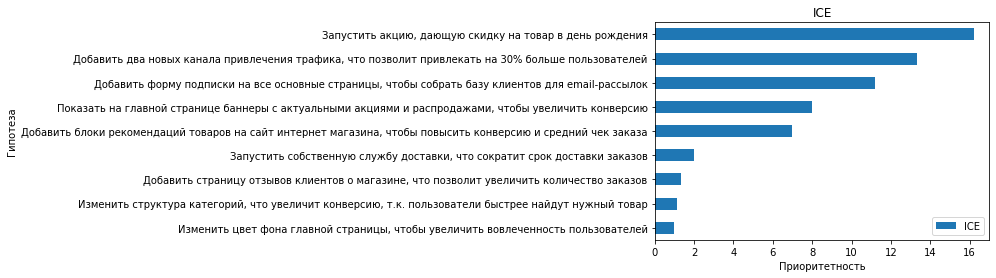

In [15]:
ax = hypothesis[['Hypothesis', 'ICE']].set_index('Hypothesis').sort_values('ICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритетность')
ax.set_ylabel('Гипотеза')
ax.set_title('ICE')
plt.show()

In [16]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values('RICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


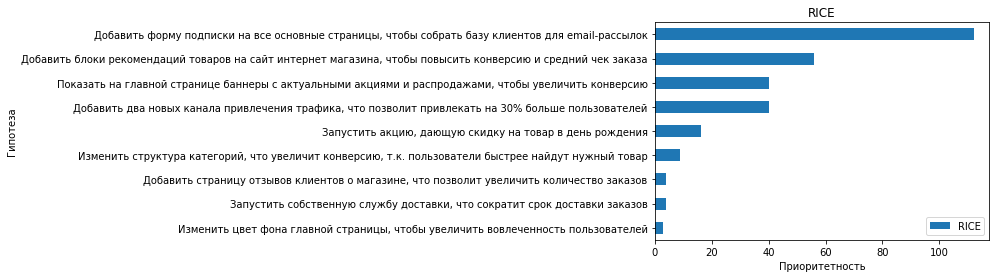

In [17]:
ax = hypothesis[['Hypothesis', 'RICE']].set_index('Hypothesis').sort_values('RICE', ascending=True).plot(kind='barh')
ax.set_xlabel('Приоритетность')
ax.set_ylabel('Гипотеза')
ax.set_title('RICE')
plt.show()

При рассмотрении ICE наивысшая приоритетность у гипотезы №8, в RICE у гипотезы №7. Это связано с тем, что показатели измеряются по разному, так RICE включает в себя также и охват гипотезы.

## Анализ А/В-теста

In [18]:
orders.head(5)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [19]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [20]:
orders_group = (orders.groupby(['date','group'], as_index=False)
                        .agg({'transaction_id':'nunique','visitor_id':'nunique','revenue':'sum'}))\
                        .rename(columns={'transaction_id':'orders','visitor_id':'buyers'})
orders_group['group_copy'] = orders_group['group']
orders_group = orders_group.set_index(['date','group'])
orders_csum = orders_group.sort_values(['date','group']).groupby('group_copy').cumsum().reset_index()

In [21]:
visitors_csum = visitors.groupby(['date','group'], as_index=False).agg({'visitors':'sum'}).sort_values(['date','group'])
visitors_csum['group_copy'] = visitors_csum['group']
visitors_csum = visitors_csum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index() 

In [22]:
cummulative = orders_csum.join(visitors_csum[['visitors']])

In [23]:
cummulative['average_purchase'] = cummulative['revenue'] / cummulative['orders']
cummulative['conversion'] = cummulative['orders'] / cummulative['visitors']

In [24]:
cummulative.head()

,date,group,orders,buyers,revenue,visitors,average_purchase,conversion
0,2019-08-01,A,24,20,148579,719,6190.791667,0.033380
1,2019-08-01,B,21,20,101217,713,4819.857143,0.029453
2,2019-08-02,A,44,39,242401,1338,5509.113636,0.032885
3,2019-08-02,B,45,43,266748,1294,5927.733333,0.034776
4,2019-08-03,A,68,63,354874,1845,5218.735294,0.036856


### Куммулятивная выручка по группам

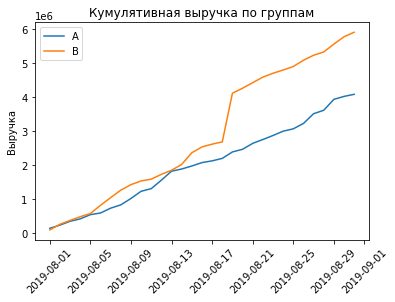

In [25]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'revenue']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'revenue']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('Кумулятивная выручка по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Выручка в группе А растет линейно, в группе В выручка также растет, но есть резкий рост выручки 17.08.2019, возможно это выброс.

### Куммулятвный средний чек по группам

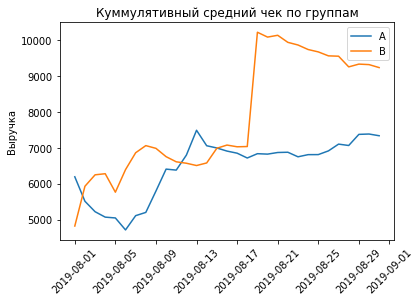

In [26]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'average_purchase']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'average_purchase']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('Куммулятивный средний чек по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

По графику среднего чека, в группе В также заметен резкий рост в ту же дату и затем снижение. 

### Относительное изменение кумулятивного среднего чека группы B к группе A

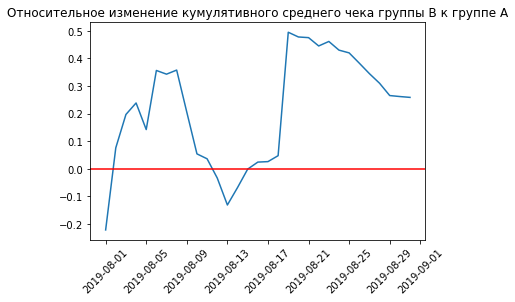

In [27]:
temp = (cummulativeA[['date', 'average_purchase']].merge(cummulativeB[['date', 'average_purchase']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['average_purchase_B'] / temp['average_purchase_A']-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()

На графике относительного куммулятивного чека та же ситуация, резкий скачок в ту же дату и затем снижение.

### Куммулятивная конверсия по группам

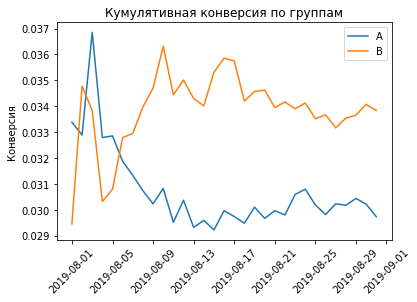

In [28]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'conversion']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'conversion']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('Кумулятивная конверсия по группам')
plt.ylabel("Конверсия")
plt.xticks(rotation=45)
plt.legend()
plt.show()

В среднем конверсия группы В выше изменяется между 0,029 и 0,036. У группы А после резкого скачка конверсии в начале до 0,037 затем конверсия снижается и остается в районе 0,029-0,031.

### Относительное изменение кумулятивной конверсии группы B к группе A

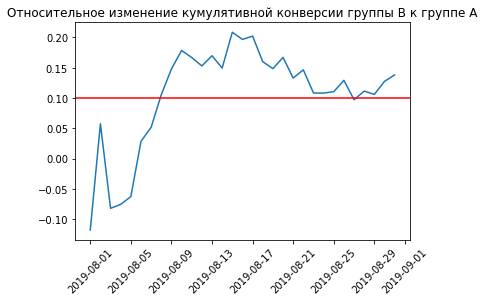

In [29]:
temp = (cummulativeA[['date', 'conversion']].merge(cummulativeB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['conversion_B'] / temp['conversion_A']-1)
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.axhline(y=0.10, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()

За месяц исследования заметно, что конверсия группы В заметно лучше, чем у группы А.

### Количество заказов по пользователям

In [30]:
orders_user = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'}).rename(columns={'transaction_id':'orders'})

In [31]:
orders_user.head(5)

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


In [32]:
orders_user['orders'].max()

11

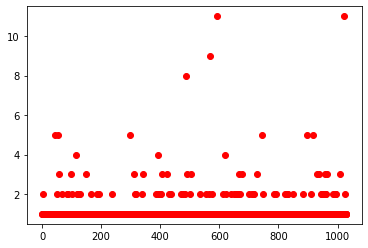

In [33]:
x_values = pd.Series(range(0,len(orders_user['orders'])))
plt.scatter(x_values, orders_user['orders'], color='red')
plt.show()

Основная часть пользователей совершает покупку в интернет-магазине 1 раз, довольно большая группа совершает покупку от 2 до 4  раз. Заметны незначительные выбросы пользователей, кто совершает покупку более 4 раз. Максимальное число заказов - 11.

### 95-й и 99-й перцентили количества заказов на пользователя, границы для определения аномальных пользователей

In [34]:
print('95 перцентиль: %.2f' % (np.percentile(orders_user['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_user['orders'], [99])))

95 перцентиль: 2.00
99 перцентиль: 4.00


In [35]:
purchase_1p = orders_user[orders_user['orders'] >= 4]['visitor_id'].to_list()

Только 5% пользователей делают больше 2 заказов, и только 1% более 4 заказов. Поэтому можно ограничить нашу выборку от выбросов, очистив данные от 1% пользователей, делающих 4 и более заказов. 

<div class="alert alert-block alert-success">
    

### Комментарий от ревьюера v_2
Отлично
    
Верное решение, отбросив 1% ты и сохранишь репрезентативность выборки, и избавишься от явных выбросов
    
</div>

### Стоимость заказов

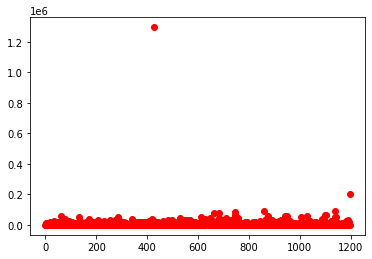

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')
plt.show()

In [37]:
orders['revenue'].max()

1294500

Вероятно на этом графике 2 выброса и есть причина скачков в группе В. Максимальная стоимость заказа - 1,3 млн? 
Из-за этого скачка по масштабу графика границы аномалий очертить сложно.

### 95-й и 99-й перцентили стоимости заказов, граница для аномальных заказов

In [38]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 28000.00
99 перцентиль: 58233.20


Только для 5% пользователей стоимость заказа превышала 28 тыс. руб., и только для 1% превышала 58,2 тыс. руб. Поэтому данные стоит также очистить от анамальных 1% пользователей с наиболее высокой стоимостью заказов.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Применим критерий Манна-Уитни и проверим гипотезы:

Н0: Конверсия в группе A равна конверсии в группе B.

H1: Конверсия в группе A не равна конверсии в группе B.

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [40]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders'] 

In [41]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [42]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [43]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


In [44]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']

In [45]:
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


### Статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [46]:
orders[orders['group']=='A']['revenue'].mean()

7333.578096947936

In [47]:
orders[orders['group']=='B']['revenue'].mean()

9230.875

Используем критерий Манна-Уитни и выдвинем следующие гипотезы:

Н0: Средний чек группы А равен среднему чеку в группе В.

Н1: Средний чек в группе А не равен среднему чеку в группе В.

In [48]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


Получается по "сырым" данным статистически значимой разницы между средними чеками в группах А и В нет. Относительная разница между чеками 25,9%, что очень много. В чем причина пока не понятно.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

In [49]:
users_purchases = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['user_id'],
    ],
    axis=0,
)

In [50]:
users_expensive = orders[orders['revenue'] > 58233]['visitor_id']

In [51]:
notnormal_users = (
    pd.concat([users_purchases, users_expensive], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [52]:
print(notnormal_users.head())

1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
dtype: int64


In [53]:
notnormal_users.shape

(20,)

In [54]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(notnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(notnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Используем критерий Манна-Уитни и выдвинем следующие гипотезы:

Н0: Конверсия в группе А равна конверсии в группе В.

Н1: Конверсия в группе А не равна конверсии в группе В.

In [55]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.014
0.151


In [56]:
orders_temp = orders[~orders['visitor_id'].isin(purchase_1p)]
conversion_clear = (orders_temp.groupby('group').agg({'transaction_id':'count'})\
.rename(columns={'transaction_id':'orders'})).join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()

In [57]:
conversion_clear['conversion'] = conversion_clear['orders'] / conversion_clear['visitors']

In [58]:
conversion_clear.head(5)

,group,orders,visitors,conversion
0,A,517,18736,0.027594
1,B,599,18916,0.031666


### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [59]:
orders_filtered = orders.query('revenue <= 58233')

In [60]:
orders_filtered[orders_filtered['group']=='A']['revenue'].mean()

6470.587272727273

In [61]:
orders_filtered[orders_filtered['group']=='B']['revenue'].mean()

6592.692913385827

Используем критерий Манна-Уитни и выдвинем следующие гипотезы:

Н0: Средний чек в группе А равен среднему чеку в группе В.

Н1: Средний чек в группе А не равен среднему чеку в группе В. 

In [62]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(notnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(notnormal_users)),)]['revenue'], True, 'two-sided')[1]))

0.959


In [63]:
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(notnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(notnormal_users)),
            )]['revenue'].mean()- 1))

-0.014


# Выводы по результатам теста

У нас были результаты А/В-теста за 1 месяц, графики в настоящий момент не стабилизировались, в связи с чем рекомендуется продолжать исследование. Конверсия у группы В в среднем выше, чем у группы А (на 15% по очщенным данным), а статистической значимой разницы в среднем чеке нет (у группы А средний чек выше на 1,4% по очищенным данным). 

Итог: продолжаем исследование.

Выводы по имеющимся гипотезам: 

1. После подсчета RICE, гипотеза №7 самая рабочая (Добавить форму подписки на все основные страницы).
2. Если для компании охват менее важен, то после подсчет ICЕ самая рабочая гипотеза №8 (Запустить акцию, дающую скидку на товар в день рождения).